# Pure Python Lazy Modified Goldstein Adaptive Filter

Run in the directory where S1A_Stack_CPGF_T173 example is processed.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
# supress numpy warnings
import warnings
warnings.filterwarnings('ignore')
from dask.distributed import Client

In [2]:
# plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
from pygmtsar import PRM
from pygmtsar import datagrid

In [4]:
%%time
# original SLC (do not flip vertically)
prm = PRM.from_file('raw_stack/S1_20150121_ALL_F1.PRM')
amp10 = prm.read_SLC_int(amplitude=True)
amp10

CPU times: user 58.7 ms, sys: 6.72 ms, total: 65.4 ms
Wall time: 77.4 ms


<xarray.DataArray 'SLC' (y: 5484, x: 21572)>
dask.array<reshape, shape=(5484, 21572), dtype=float32, chunksize=(512, 21572), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 5.482e+03 5.482e+03 5.484e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 2.157e+04 2.157e+04 2.157e+04

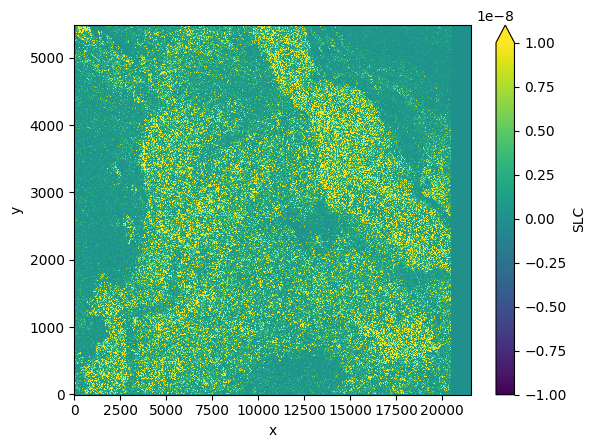

In [5]:
amp10[::8,::8].plot.imshow(vmin=-1e-8, vmax=1e-8)

In [6]:
%%time
# original SLC (do not flip vertically)
prm = PRM.from_file('raw_stack/S1_20150121_ALL_F1.PRM')
amp10 = prm.read_SLC_int(amplitude=False)
amp10

CPU times: user 6.51 ms, sys: 1.28 ms, total: 7.79 ms
Wall time: 6.95 ms


<xarray.DataArray 'SLC' (y: 5484, x: 21572)>
dask.array<reshape, shape=(5484, 21572), dtype=complex64, chunksize=(512, 21572), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 5.482e+03 5.482e+03 5.484e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 2.157e+04 2.157e+04 2.157e+04

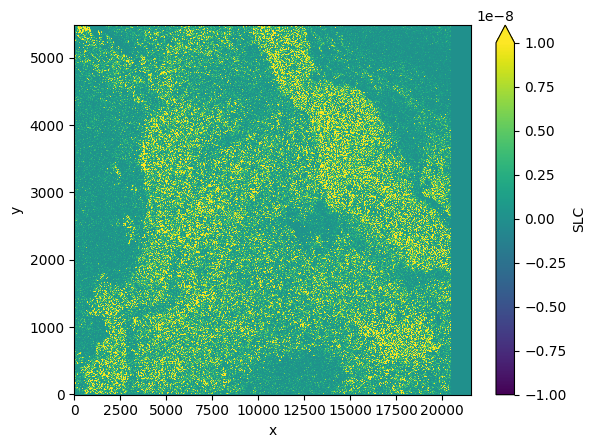

In [7]:
(abs(amp10)**2)[::8,::8].plot.imshow(vmin=-1e-8, vmax=1e-8)

In [8]:
if 'client' in globals():
    client.close()
client = Client(memory_limit='2GB')
client

<Client: 'tcp://127.0.0.1:57634' processes=4 threads=8, memory=7.45 GiB>

In [9]:
# Open phasefilt tool output files (flip vertically)
out_phase = xr.open_dataarray('raw_stack/F1_20150121_20150310_phasefilt_phase.grd')
out_phase.values = np.flipud(out_phase)
out_corr  = xr.open_dataarray('raw_stack/F1_20150121_20150310_phasefilt_corr.grd')
out_corr.values = np.flipud(out_corr)
out_phase.shape, out_corr.shape

((5484, 5393), (5484, 5393))

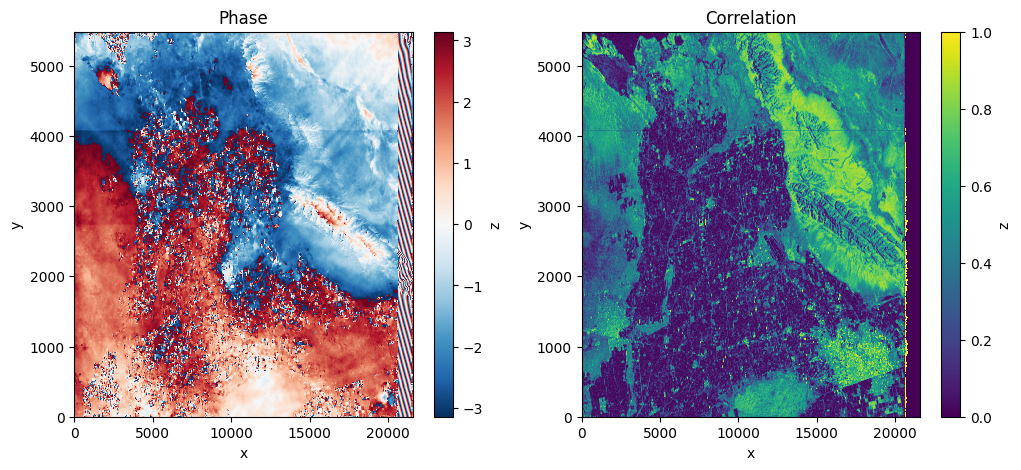

CPU times: user 570 ms, sys: 154 ms, total: 724 ms
Wall time: 707 ms


In [10]:
%%time
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12,5))

out_phase.plot.imshow(ax=axs[0])
axs[0].set_title('Phase')

out_corr.plot.imshow(ax=axs[1])
axs[1].set_title('Correlation')

plt.show()

In [11]:
%%time
import dask.array

# original SLC (do not flip vertically)
prm = PRM.from_file('raw_stack/S1_20150121_ALL_F1.PRM')
prm = PRM.from_file('raw_stack/S1_20150310_ALL_F1.PRM')
# convert to amplitudes
amp10 = prm.read_SLC_int(amplitude=True)
amp20 = prm.read_SLC_int(amplitude=True)

# Open phasediff tool output files (flip vertically)
imag0 = xr.open_dataarray('imag.nc', engine=datagrid.engine, chunks=datagrid.chunksize)
imag0.data = dask.array.flipud(imag0)
real0 = xr.open_dataarray('real.nc', engine=datagrid.engine, chunks=datagrid.chunksize)
real0.data = dask.array.flipud(real0)

imag0

CPU times: user 47.7 ms, sys: 7.45 ms, total: 55.2 ms
Wall time: 56.3 ms


<xarray.DataArray 'z' (y: 5484, x: 21572)>
dask.array<getitem, shape=(5484, 21572), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 2.157e+04 2.157e+04 2.157e+04
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 5.482e+03 5.482e+03 5.484e+03
Attributes:
    long_name:     z
    actual_range:  [-3.09737261e-05  8.42787558e-05]

In [12]:
%%time

wavelength = 400

# anti-aliasing filter for multi-looking
imag = prm.antialiasing_downscale(imag0, wavelength=wavelength)
real = prm.antialiasing_downscale(real0, wavelength=wavelength)
amp1 = prm.antialiasing_downscale(amp10, wavelength=wavelength)
amp2 = prm.antialiasing_downscale(amp20, wavelength=wavelength)

imag.shape, real.shape, amp1.shape, amp2.shape

CPU times: user 27.5 ms, sys: 3.93 ms, total: 31.5 ms
Wall time: 32 ms


((5484, 5393), (5484, 5393), (5484, 5393), (5484, 5393))

CPU times: user 2.99 s, sys: 490 ms, total: 3.48 s
Wall time: 5.21 s


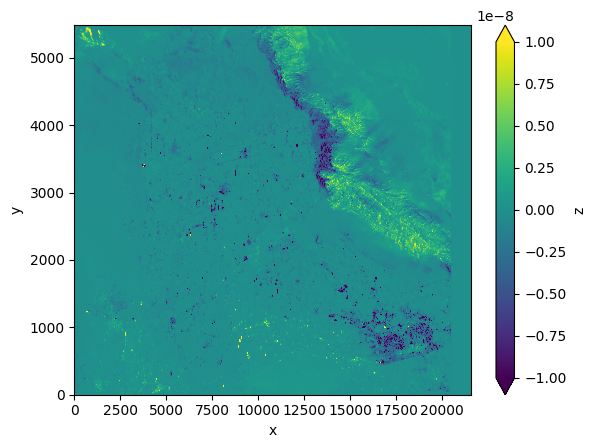

In [13]:
%%time
# check vertical orientation
real.plot.imshow(vmin=-1e-8, vmax=1e-8)

CPU times: user 347 ms, sys: 146 ms, total: 494 ms
Wall time: 2.53 s


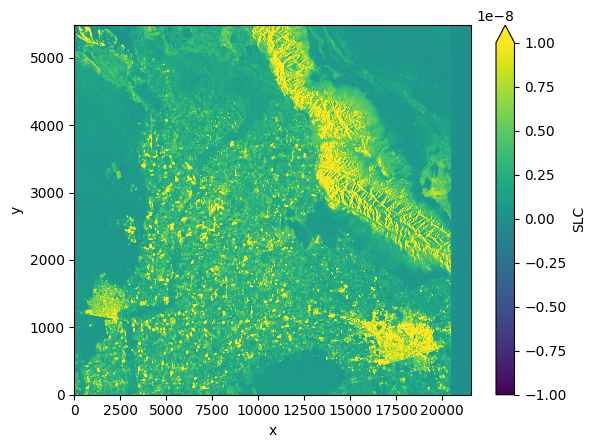

In [14]:
%%time
# check vertical orientation 
amp1.plot.imshow(vmin=-1e-8, vmax=1e-8)

In [15]:
%%time
amp = np.sqrt(real**2 + imag**2)
amp

CPU times: user 2.45 ms, sys: 2.25 ms, total: 4.7 ms
Wall time: 4.22 ms


<xarray.DataArray 'z' (y: 5484, x: 5393)>
dask.array<sqrt, shape=(5484, 5393), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2.0 6.0 10.0 14.0 ... 2.156e+04 2.157e+04 2.157e+04
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 5.482e+03 5.482e+03 5.484e+03

In [16]:
%%time
corr = PRM.correlation(amp1, amp2, amp)
corr

CPU times: user 11.1 ms, sys: 2.1 ms, total: 13.2 ms
Wall time: 12.6 ms


<xarray.DataArray 'phase' (y: 5484, x: 5393)>
dask.array<rechunk-merge, shape=(5484, 5393), dtype=float32, chunksize=(512, 5393), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 5.482e+03 5.482e+03 5.484e+03
  * x        (x) float64 2.0 6.0 10.0 14.0 ... 2.156e+04 2.157e+04 2.157e+04

/opt/homebrew/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/homebrew/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/homebrew/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/homebrew/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 8.99 s, sys: 1.14 s, total: 10.1 s
Wall time: 16.8 s


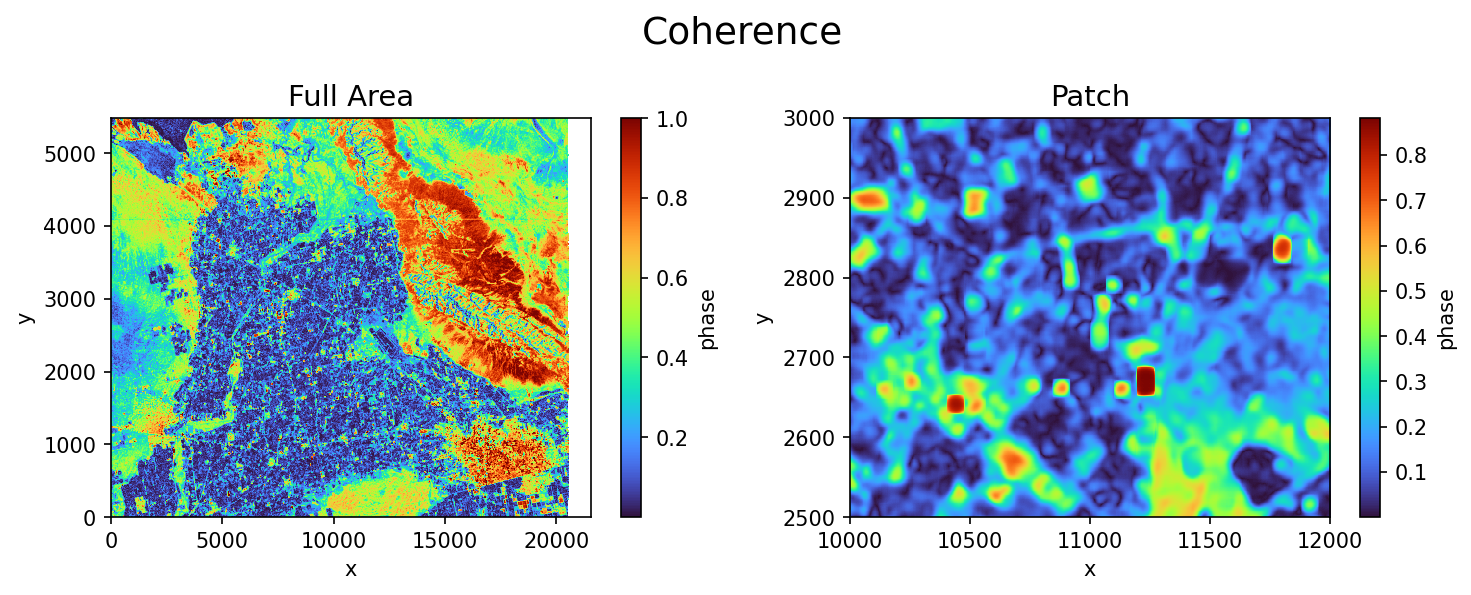

In [17]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

im2 = corr.plot.imshow(cmap='turbo', ax=axs[0])
axs[0].set_title('Full Area', fontsize=14)

im2 = corr[2500:3000,2500:3000].plot.imshow(cmap='turbo', ax=axs[1])
axs[1].set_title('Patch', fontsize=14)

# Set the main title for the figure
fig.suptitle('Coherence', fontsize=18)

plt.tight_layout()

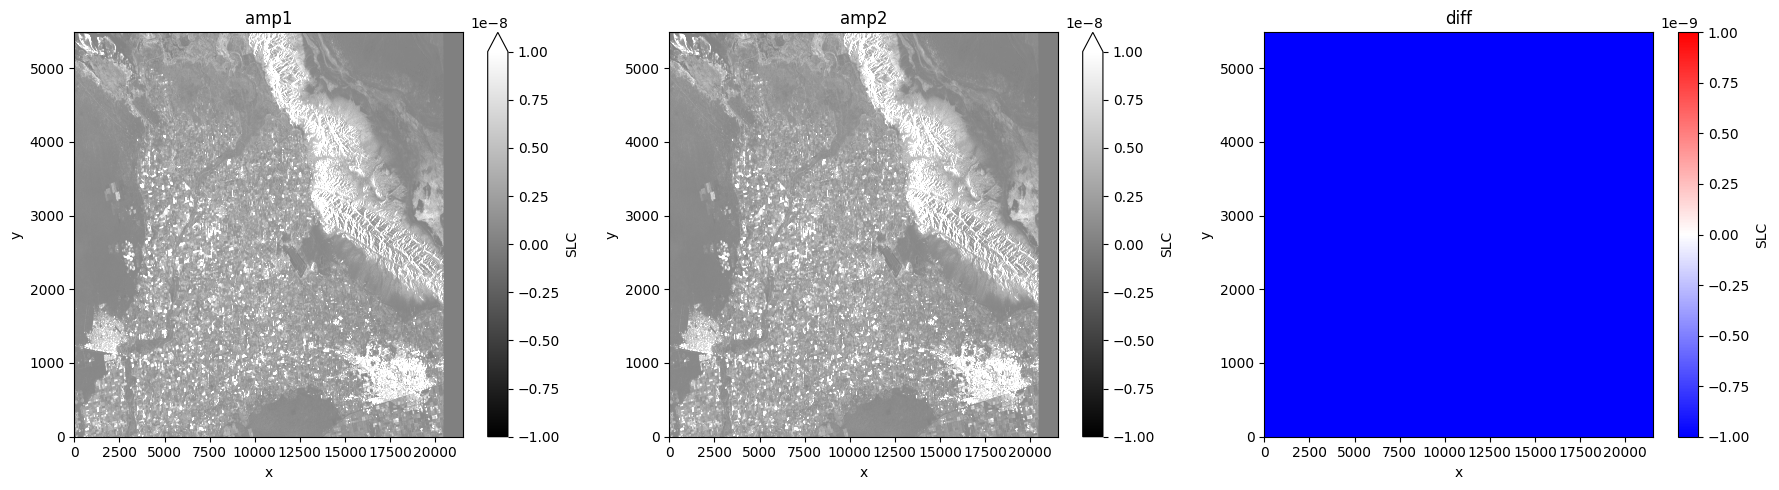

CPU times: user 1.46 s, sys: 511 ms, total: 1.97 s
Wall time: 6.81 s


In [18]:
%%time
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

amp1.plot.imshow(vmin=-1e-8, vmax=1e-8, cmap='gray', ax=ax0)
ax0.set_title('amp1')

amp2.plot.imshow(vmin=-1e-8, vmax=1e-8, cmap='gray', ax=ax1)
ax1.set_title('amp2')

(amp1-amp2).plot.imshow(vmin=-1e-9, vmax=1e-9, cmap='bwr', ax=ax2)
ax2.set_title('diff')

plt.tight_layout()
plt.show()

In [19]:
%%time

phase = PRM.goldstein_filter_parallel((real + 1j * imag), corr, psize=32)
phase

CPU times: user 6.63 ms, sys: 900 µs, total: 7.53 ms
Wall time: 6.81 ms


<xarray.DataArray 'phase' (y: 5484, x: 5393)>
dask.array<rechunk-merge, shape=(5484, 5393), dtype=float32, chunksize=(512, 5393), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 5.482e+03 5.482e+03 5.484e+03
  * x        (x) float64 2.0 6.0 10.0 14.0 ... 2.156e+04 2.157e+04 2.157e+04

In [20]:
%%time
# on small grid: array(0.00010673) Wall time: 8.7 s
# on full grid 60m wavelength: 34.8s
# on full grid 400m wavelength: 56.5s
np.sqrt(((xr.DataArray(phase, dims=corr.dims).compute() - out_phase)**2).sum())/corr.size

CPU times: user 8.45 s, sys: 1.05 s, total: 9.5 s
Wall time: 17.5 s


<xarray.DataArray ()>
array(0.00010443)

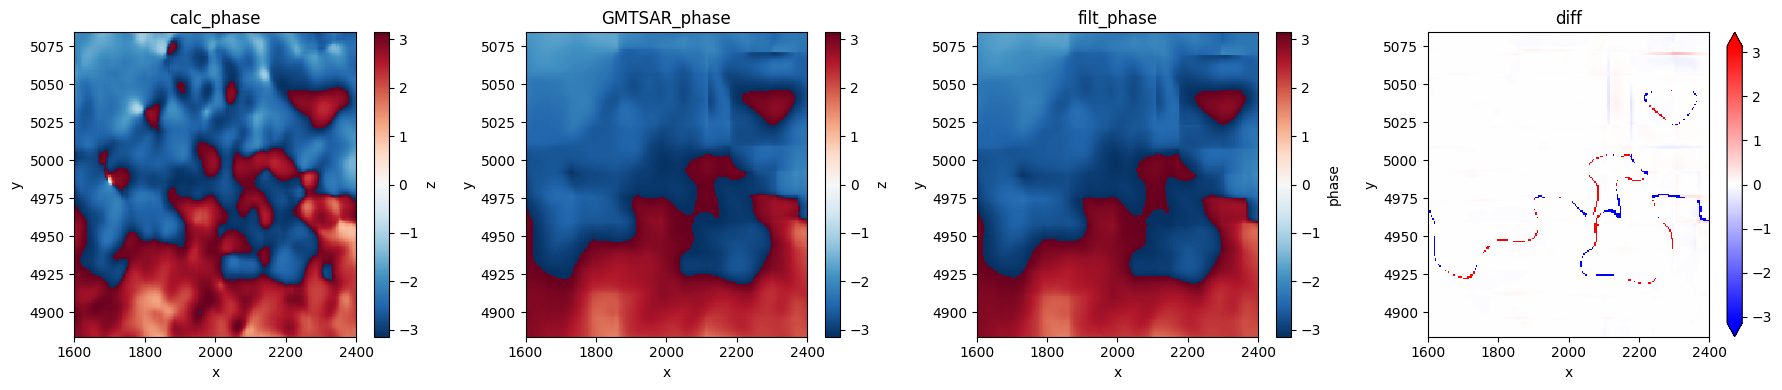

CPU times: user 5.17 s, sys: 695 ms, total: 5.86 s
Wall time: 9.86 s


In [21]:
%%time
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

y1 = 400
y2 = 600
x1 = 400
x2 = 600

# flip vertically
y1, y2 = imag.shape[0]-y2, imag.shape[0]-y1

np.arctan2(imag, real)[y1:y2,x1:x2].plot.imshow(ax=ax0)
ax0.set_title('calc_phase')

out_phase[y1:y2,x1:x2].plot.imshow(ax=ax1)
ax1.set_title('GMTSAR_phase')

phase[y1:y2,x1:x2].plot.imshow(ax=ax2)
ax2.set_title('filt_phase')

(phase - out_phase)[y1:y2,x1:x2].plot.imshow(vmin=-np.pi, vmax=np.pi, cmap='bwr', ax=ax3)
ax3.set_title('diff')

plt.tight_layout()
plt.show()

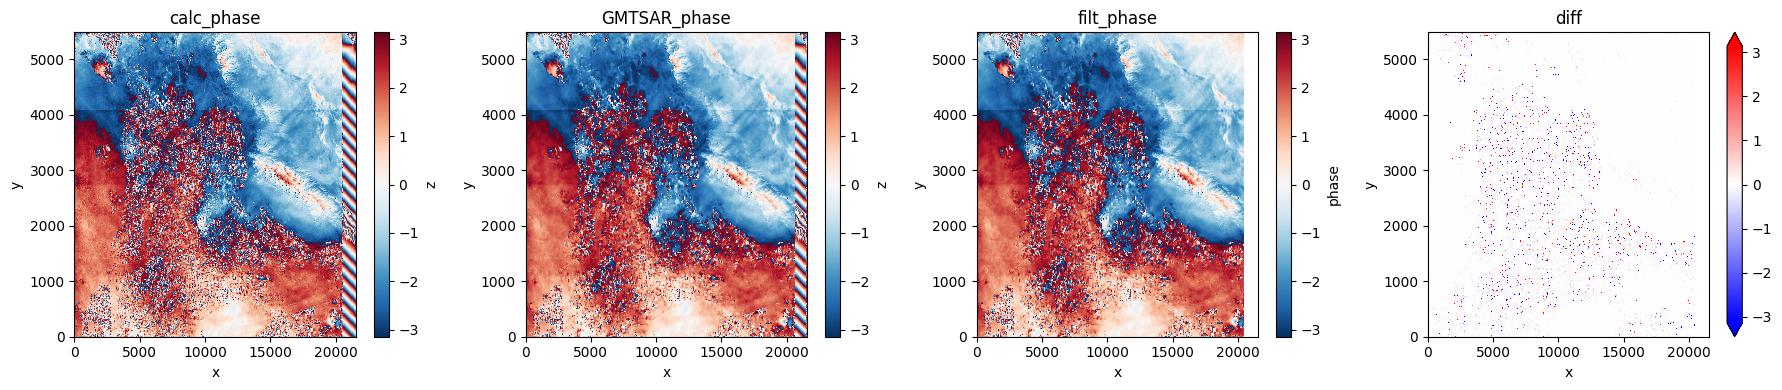

CPU times: user 23.8 s, sys: 3.09 s, total: 26.9 s
Wall time: 46.2 s


In [22]:
%%time
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

np.arctan2(imag, real).plot.imshow(ax=ax0)
ax0.set_title('calc_phase')

out_phase.plot.imshow(ax=ax1)
ax1.set_title('GMTSAR_phase')

phase.plot.imshow(ax=ax2)
ax2.set_title('filt_phase')

(phase - out_phase).plot.imshow(vmin=-np.pi, vmax=np.pi, cmap='bwr', ax=ax3)
ax3.set_title('diff')

plt.tight_layout()
plt.show()

CPU times: user 7.17 s, sys: 895 ms, total: 8.07 s
Wall time: 13.5 s


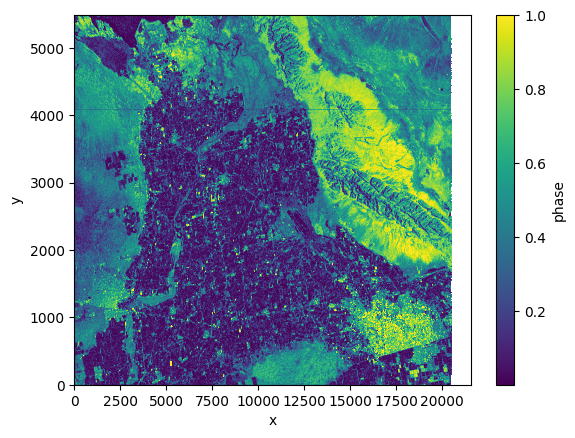

In [23]:
%%time
corr.plot.imshow()

CPU times: user 142 ms, sys: 35.3 ms, total: 177 ms
Wall time: 174 ms


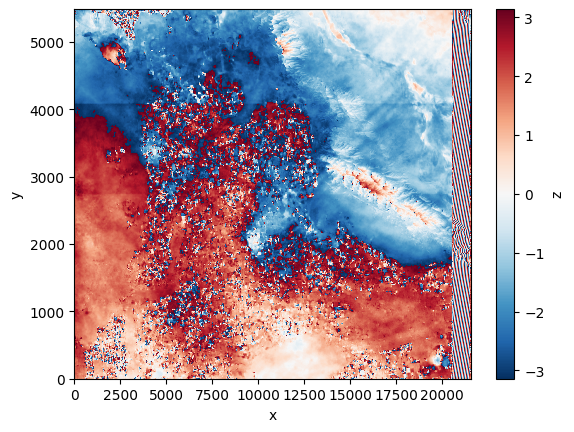

In [24]:
%%time
out_phase.plot.imshow()

CPU times: user 8.26 s, sys: 1.1 s, total: 9.35 s
Wall time: 17.5 s


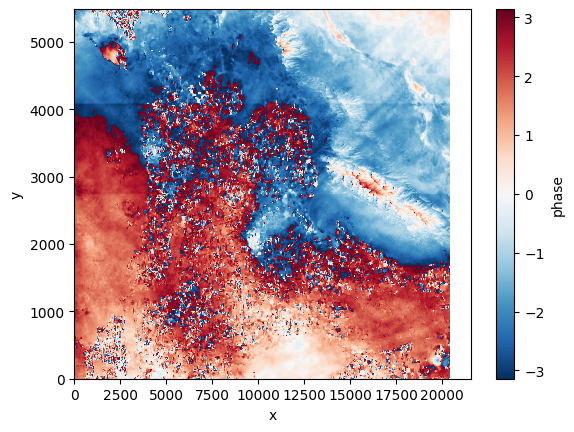

In [25]:
%%time
phase.plot.imshow()

CPU times: user 6.21 s, sys: 868 ms, total: 7.07 s
Wall time: 10.1 s


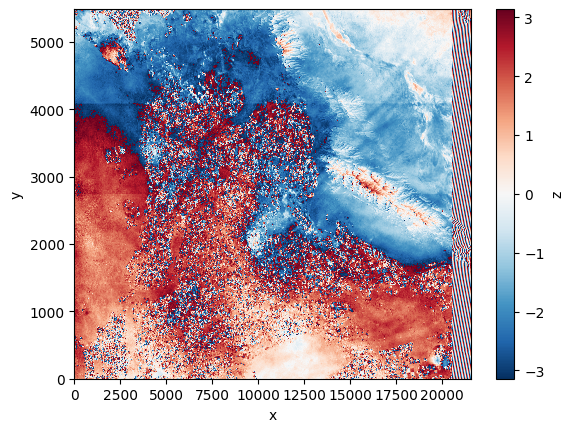

In [26]:
%%time
np.arctan2(imag, real).plot.imshow()